Смотрим на ревизии подряд. Смотрим только добавленные документы

In [1]:
from wikiparser_utils import WikiXMLDump, WikiPage
import os
import nltk
import json
import numpy as np
from tqdm.notebook import tqdm
from difflib import Differ 
from utils.difflibparser import DifflibParser, DiffCode

import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
from io import StringIO, BytesIO
from PyPDF2 import PdfReader, PdfFileReader
import urllib3
import html2text
import os
import time
from os import listdir
from os.path import isfile, join

/home/ubuntu/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (4.0.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
from selenium.webdriver.chrome.options import Options
from urllib3.util import Timeout
timeout = Timeout(total=60.0)
http_urllib = urllib3.PoolManager(timeout=timeout)
options = Options()
options.headless = True

In [3]:
dump = WikiXMLDump('history.xml')

In [4]:
DOCS_DIR = 'data/documents'
DOCS_MAPPER_DIR = 'data/documents_mapper'

if not os.path.exists(DOCS_MAPPER_DIR):
    os.makedirs(DOCS_MAPPER_DIR)
    
if not os.path.exists(DOCS_DIR):
    os.makedirs(DOCS_DIR)
    

In [5]:
dirs = sorted(os.listdir('data/pages'))
page_names = list(map(lambda x: '_'.join(x.split('_')[:-1]), dirs))
dirs[:5], page_names[:5]

(['01JJC_2934682',
  '10 OClock News_2934804',
  '125 BC_2934966',
  '15020421743_2935130',
  '151199192110_2935750'],
 ['01JJC', '10 OClock News', '125 BC', '15020421743', '151199192110'])

In [6]:
from collections import Counter
popular_words = Counter()
for p_name in page_names:
    toks = list(map(lambda x: x.lower(), p_name.split()))
    popular_words.update(toks)
print(popular_words.most_common(20))

[('of', 57), ('for', 37), ('articles', 27), ('the', 23), ('in', 17), ('and', 17), ('district', 15), ('boeing', 12), ('list', 11), ('de', 9), ('railway', 8), ('station', 8), ('new', 7), ('burnham', 7), ('river', 7), ('beaked', 6), ('whale', 6), ('grocers', 6), ('school', 6), ('austria', 6)]


In [7]:
# попробуем разбить названия стариц на кластера
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

In [8]:
print(api.load('glove-wiki-gigaword-50', return_path=True))

/home/ubuntu/gensim-data/glove-wiki-gigaword-50/glove-wiki-gigaword-50.gz


In [9]:
model = api.load("glove-wiki-gigaword-50")
model.most_similar("glass")

[('plastic', 0.7942506074905396),
 ('metal', 0.770871639251709),
 ('walls', 0.7700635194778442),
 ('marble', 0.7638523578643799),
 ('wood', 0.7624281048774719),
 ('ceramic', 0.7602593302726746),
 ('pieces', 0.7589111328125),
 ('stained', 0.7528817653656006),
 ('tile', 0.748193621635437),
 ('furniture', 0.7463858723640442)]

In [10]:
model['glass'].shape

(50,)

In [11]:
pn2vector = {}
for pn in page_names:
    pn_toks = pn.split()
    vec, counter = 0, 0
    for pn_tok in pn_toks:
        try:
            vec += model[pn_tok]
            counter += 1
        except:
            continue
    if counter > 0:
        final_vec = vec / counter
        pn2vector[pn] = final_vec
        

In [12]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

pns = np.array(list(pn2vector))
vecs = list(pn2vector.values())

kmeans = KMeans(n_clusters=10, random_state=0).fit(vecs)
colors = kmeans.labels_
cent = kmeans.cluster_centers_


tsne = TSNE(n_components=2, verbose=1, n_iter=300)
tsne_results = tsne.fit_transform(vecs + list(cent))
tsne_results, tsne_centers = tsne_results[:-len(cent)], tsne_results[-len(cent):]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 326 samples in 0.001s...
[t-SNE] Computed neighbors for 326 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 326 / 326
[t-SNE] Mean sigma: 1.329954
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.441727
[t-SNE] KL divergence after 300 iterations: 1.315884


In [13]:
tsne_results = np.clip(tsne_results, -30, 30)
tsne_centers = np.clip(tsne_centers, -30, 30)

In [14]:
tsne_centers

array([[-12.370581 ,  12.354931 ],
       [-27.100317 , -30.       ],
       [ -0.9733109,  -5.049675 ],
       [ -8.964512 ,  -5.372946 ],
       [  4.7590003,  -9.084736 ],
       [ -0.5360183, -17.907578 ],
       [ -0.5112891, -14.282129 ],
       [  4.6032033,  -2.8537023],
       [ 14.759792 ,  10.159762 ],
       [  2.680347 ,   5.212805 ]], dtype=float32)

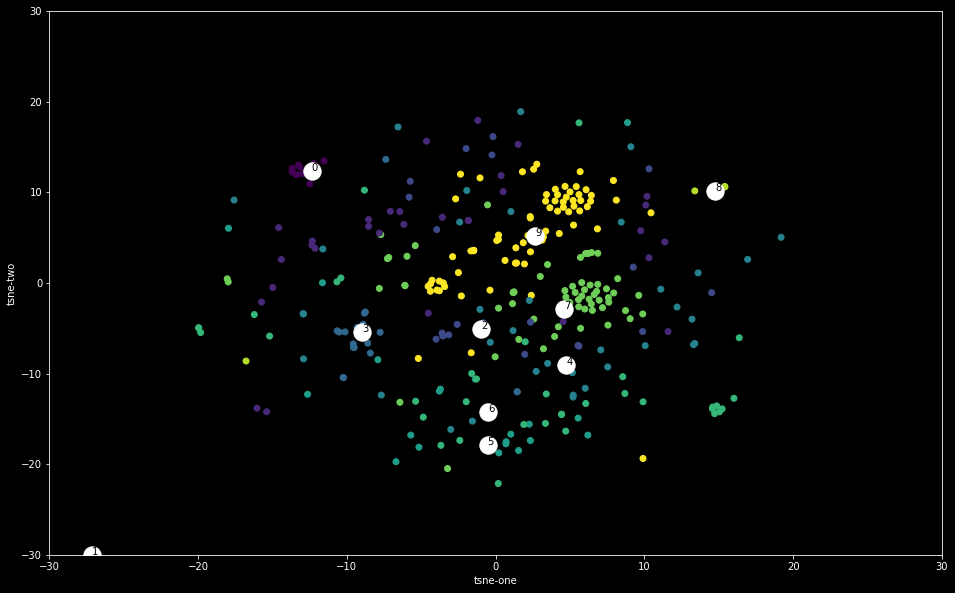

In [15]:
plt.style.use('dark_background')
plt.figure(figsize=(16, 10))
plt.scatter(
    x=tsne_results[:, 0], 
    y=tsne_results[:, 1], 
    c=colors, 
)
plt.scatter(
    x=tsne_centers[:, 0], 
    y=tsne_centers[:, 1], 
    c='white',
    s=300
)

for i, txt in enumerate(tsne_centers):
    plt.annotate(str(i), (tsne_centers[i, 0], tsne_centers[i, 1]), c='black')

plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.xlabel('tsne-one')
plt.ylabel('tsne-two')
plt.show()

Самый осознанный кластер = 0. Посмотрим что объединяет названия старниц в нем

In [16]:
pns[colors == 0] # кластер с именами собственными

array(['Assurances Generales de France', 'Hugues de SaintVictor',
       'Jacobus de Voragine', 'Jamil el Banna',
       'Jardim Botânico Rio de Janeiro',
       'JeanLouis Anne Madelain Cardinal Lefebvre de Cheverus',
       'Paso de los Libres', 'Real Club Celta de Vigo',
       'Rodrigo de Freitas Lagoon', 'Velours du Kasaï'], dtype='<U85')

In [18]:
pns[colors == 9][:10] # ??

array(['2003 Liberation of Iraq', 'Affiliated Foods Stores of Amarillo',
       'Articles for deletionSons of Alexander',
       'Associated Grocers of Maine', 'Associated Grocers of New England',
       'Battle of Frigidus', 'Battle of Gvozd Mountain',
       'Blinx 2 Masters of Time and Space',
       'Blue Stars Drum and Bugle Corps', 'Bob and Larry'], dtype='<U85')

In [19]:
pns[colors == 8][:10] # районы и юрисдикции

array(['Dakshin Dinajpur district', 'Jalpaiguri district',
       'Pendent jurisdiction', 'Sessions court',
       'Uttar Dinajpur district'], dtype='<U85')